In [5]:
import os
import shutil
import subprocess
import xarray as xr
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from datetime import datetime, timedelta

In [12]:
class NCHelper:
    def __init__(self, dataset, dir_path):
        # read the dataset
        print("reading dataset...")
        try:
            self.ds = xr.open_dataset(dataset)
        except:
            raise Exception("reading dataset failed")
        print("reading dataset done")
        
        # create new directory
        self.dir_path = dir_path
        if os.path.exists(dir_path):
            shutil.rmtree(dir_path)
        os.mkdir(dir_path)

    def nc2asc(self, var, lat, lon, asc_name):
        # prepare the variables
        ncols = len(lon.values)
        nrows = len(lat.values)
        xllcorner = lon[0].values
        yllcorner = lat[-1].values
        cellsize = abs(lat[0].values - lat[1].values)
        NODATA_value = -9999
        grid = var.values

        # generate ascii grid file
        print(f"generating {asc_name} ascii grid...")
        with open(f"{self.dir_path}/{asc_name}.asc", "w") as file:
            file.write(f"ncols {ncols}\n")
            file.write(f"nrows {nrows}\n")
            file.write(f"xllcorner {xllcorner}\n")
            file.write(f"yllcorner {yllcorner}\n")
            file.write(f"cellsize {cellsize}\n")
            file.write(f"NODATA_value {NODATA_value}\n")
            for i in grid:
                for j in i:
                    file.write(f"{j} ")
                file.write("\n")
        print(f"file: {os.getcwd()}/{self.dir_path}/{asc_name}.asc".replace("\\", "/"))

    def nc2image(self, var, img_name, x_dim, y_dim, cmap="turbo", flip=None):
        # generate gray geotiff image
        print(f"generating {img_name} the images...")
        img_dir = f"{self.dir_path}/{img_name}"
        _var = var.rio.set_spatial_dims(x_dim=x_dim, y_dim=y_dim)
        _var.rio.crs
        _var.rio.write_crs("epsg:4326", inplace=True)
        _var.rio.to_raster(f"{img_dir}.tiff")

        # read the gray geotiff image data
        var_tiff_raster = rasterio.open(f"{img_dir}.tiff")
        data = var_tiff_raster.read(1)
        if flip != None:
            data = np.flip(data, axis=flip)
        _cmap = None

        # using color table from defined txt file
        if ".txt" in cmap:
            custom_colors = []
            with open(cmap, "r") as file:
                lines = file.readlines()
                for line in lines:
                    values = line.split()
                    if (len(values) == 4):
                        r, g, b = int(values[1]), int(values[2]), int(values[3])
                        custom_colors.append((r, g, b))
                    else:
                        raise Exception(f"the {cmap} does not match the template")

            custom_colors_normalized = [
                (r / 255, g / 255, b / 255) for r, g, b in custom_colors
            ]
            _cmap = ListedColormap(custom_colors_normalized)
        # using color table from matplotlib template
        else:
            _cmap = plt.get_cmap(cmap)

        # create rgb map figure
        fig, ax = plt.subplots(figsize=(10, 8))
        img = ax.imshow(data, cmap=_cmap)
        ax.set_xticks([])
        ax.set_yticks([])

        # save the map figure as png image
        fig.savefig(
            f"{img_dir}.png",
            dpi=300,
            bbox_inches="tight",
            transparent=True,
            pad_inches=-0.1,
        )

        # create colorbar figure
        colorbar_fig, colorbar_ax = plt.subplots(figsize=(10, 0.3))
        colorbar_fig.colorbar(img, cax=colorbar_ax, orientation="horizontal")

        # save the colorbar figure as png image
        colorbar_fig.savefig(
            f"{img_dir}_colorbar.png", dpi=300, bbox_inches="tight", transparent=True
        )

        # read the rgb map png image
        dataset = rasterio.open(f"{img_dir}.png")
        bands = [1, 2, 3]
        data = dataset.read(bands)
        bounds = var_tiff_raster.bounds
        transform = rasterio.transform.from_bounds(
            bounds.left,
            bounds.top,
            bounds.right,
            bounds.bottom,
            data.shape[1],
            data.shape[2],
        )

        # save the rgb image as geotiff image
        with rasterio.open(
            f"{img_dir}_rgb.tiff",
            "w",
            driver="GTiff",
            width=data.shape[1],
            height=data.shape[2],
            count=3,
            dtype=data.dtype,
            nodata=0,
            transform=transform,
            crs=var_tiff_raster.crs,
        ) as dst:
            dst.write(data, indexes=bands)

        print(f"output: {os.getcwd()}/{img_dir}.tiff".replace("\\", "/"))
        print(f"output: {os.getcwd()}/{img_dir}.png".replace("\\", "/"))
        print(f"output: {os.getcwd()}/{img_dir}_colorbar.png".replace("\\", "/"))
        print(f"output: {os.getcwd()}/{img_dir}_rgb.tiff".replace("\\", "/"))

        # close the openned file
        var_tiff_raster.close()
        dataset.close()

    def geotiff2tiles(self, gdal2tiles, img_name, zoom="5-7", processes=1):
        if not os.path.exists(f"{self.dir_path}/{img_name}_rgb.tiff"):
            raise Exception("run nc2asc() first to generate the geotiff image")

        # generate the tiles with gdal2tiles.py
        # https://gdal.org/programs/gdal2tiles.html
        subprocess.run(
            [
                "python",
                gdal2tiles,
                f"{self.dir_path}/{img_name}_rgb.tiff",
                f"{self.dir_path}/tiles/{img_name}",
                f"--zoom={zoom}",
                f"--processes={processes}",
            ]
        )

In [ ]:
date = datetime.now().replace(hour=00)
# date_str = date.strftime("%Y%m%d%H")
date_str = "2023110700"
dataset_url = f"http://182.16.248.173:8080/dods/INA-NWP/{date_str}/{date_str}-d01-asim"
nch = NCHelper(
    dataset_url,
    dir_path=f"storage/{date_str}",
)

c:\Users\falbas\miniconda3\Lib\site-packages\rasterio\__init__.py:317: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


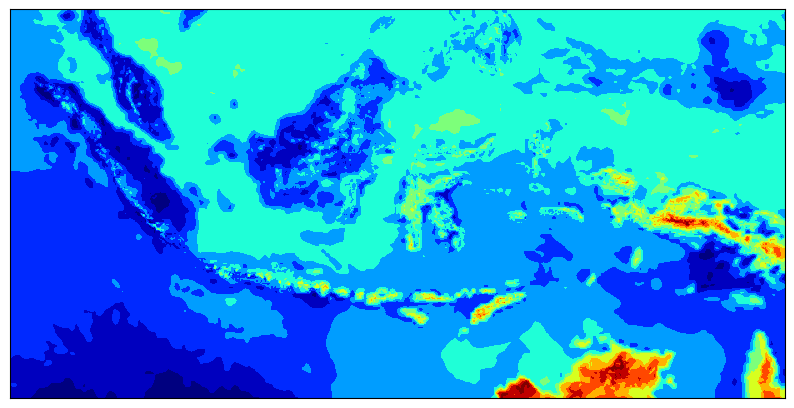

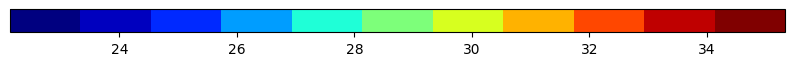

In [46]:
tc = nch.ds["tc"]
nch.nc2image(tc[0][0], "tc", x_dim="lon", y_dim="lat", flip=0, cmap="tc_color.txt")

In [50]:
nch.geotiff2tiles("C:/Users/falbas/miniconda3/Scripts/gdal2tiles.py", "tc", "5-7", 16)